# Librairies


In [187]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pyreadr
import xarray

# Préalable

## Initialisation

In [188]:
def initialize(ni,ri):
    Ui = np.zeros((ni, ri))
    indices = np.array_split(np.arange(ni), ri)
    for j, idx in enumerate(indices):
        Ui[idx, j] = 1 / np.sqrt(len(idx))

    return Ui

def initialize_G(r1,r2,r3):
    G= np.random.rand(r1,r2,r3)

    return G

## Calcul de l'erreur

In [189]:
def etalT(T):
    n1, n2, n3 = T.shape
    T_prime=T.reshape(n1, n2 * n3)
    return T_prime

def U23G(U2, U3, G):
    # étape 0 : 
    G_=G[:,:,0]*U3[0,0]
    for i in range (1,U3.shape[1]):   
        G_=G_+G[:,:,i]*U3[0,i]
    U23=G_@U2.T

    for j in range (1, U3.shape[0]):
        G_=G[:,:,0]*U3[j,0]
        for i in range (1,U3.shape[1]):   
            G_=G_+G[:,:,i]*U3[j,i]
        U23=np.bmat([[U23 , G_@U2.T]])
    return U23

def calcul_error(T, G, U1, U2, U3):
    Mat=U1 @ U23G(U2, U3, G)
    T_prime=etalT(T)
    error=np.linalg.norm(T_prime-Mat)/np.linalg.norm(T_prime)
    return error
def calcul_e(T_,U,i,U23g):
    Mat=U[i,:] @ U23g  
    t=T_[i,:]
    error=np.linalg.norm(t-Mat)/np.linalg.norm(t)
    return error

def U_normalize(U):
    m,n=U.shape
    for i in range(n):
        norm=np.linalg.norm(U[:,i])
        if norm > 0 and norm == True:   
            U[:,i]=U[:,i]/norm
    return U

## Optimisation

In [190]:
def mode_n_product(X, M, mode):
    Xm = np.moveaxis(X, mode, 0)            
    Y = np.tensordot(M, Xm, axes=(1,0))      
    return np.moveaxis(Y, 0, mode) 

def optiG(T,U1,U2,U3,G,rcond=None):

    U1=U_normalize(U1)
    U2=U_normalize(U2)
    U3=U_normalize(U3)
    
    pinv1 = U1.T
    pinv2 = U2.T
    pinv3 = U3.T
    G = mode_n_product(T, pinv1, mode=0)
    G = mode_n_product(G, pinv2, mode=1)
    G = mode_n_product(G, pinv3, mode=2)
    return G

In [191]:
def optiU(T, U, U2, U3, G):
    T_ = etalT(T)
    n1 = T.shape[0]
    r1 = G.shape[0]

    U_save = U.copy()
    value_save = calcul_error(T, G, U_save, U2, U3)

    U23g = U23G(U2, U3, G)  
    eps = 1e-12  

    for i in range(n1):

        best_j = 0
        best_val = float('inf')

        for j in range(r1):

            U_tmp = U[i].copy()
            U_tmp[:] = 0

            denom = np.linalg.norm(U23g[j, :])**2 + eps
            U_tmp[j] = (T_[i, :] @ U23g[j, :].T) / denom

            U_test = U.copy()
            U_test[i, :] = U_tmp

            val = calcul_e(T_, U_test, i, U23g)

            if val < best_val:
                best_val = val
                best_j = j

        U[i, :] = 0
        denom = np.linalg.norm(U23g[best_j, :])**2 + eps
        U[i, best_j] = (T_[i, :] @ U23g[best_j, :].T) / denom

    best_value = calcul_error(T, G, U, U2, U3)
    if best_value > value_save:
        return U_save, value_save
    else:
        return U, best_value


In [192]:
def Optimization(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()

    for i in range (max_iter):


        T1 = T  
        U1,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        print(f"Erreur U1 : {err}")

        T2 = np.transpose(T, (1, 0, 2))  
        U2,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        print(f"Erreur U2 : {err}")
      
        T3 = np.transpose(T, (2, 0, 1))  
        U3,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))
        erreurU3.append(err)
        print(f"Erreur U3 : {err}")

        G=optiG(T,U1,U2,U3,G)

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        print(f"__________itération {i+1} __________")
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

In [193]:
def Optimization_avec_compteur(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()

    compteur=0
    for i in range (max_iter):


        T1 = T  
        U1,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        print(f"Erreur U1 : {err}")
        if i>1 and abs(erreurU1[-1]-erreurU1[-2])<tol*100:
            compteur+=1
            if compteur==5:
                U1=initialize(U1.shape[0],U1.shape[1])
                print( "Reinitialisation U1")
                compteur=1
        else:
            if compteur>0:
                compteur-=1
        print("compteur :",compteur)
        


        T2 = np.transpose(T, (1, 0, 2))  
        U2,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        print(f"Erreur U2 : {err}")
        if i>1 and abs(erreurU2[-1]-erreurU2[-2])<tol*100:
            compteur+=1
            if compteur==5:
                U2=initialize(U2.shape[0],U2.shape[1])
                print( "Reinitialisation U2")
                compteur=1
        else:
            if compteur>0:
                compteur-=1
        print("compteur :",compteur)

        T3 = np.transpose(T, (2, 0, 1))  
        U3,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))
        erreurU3.append(err)
        print(f"Erreur U3 : {err}")
        if i>1 and abs(erreurU3[-1]-erreurU3[-2])<tol*100:
            compteur+=1
            if compteur==5:
                U3=initialize(U3.shape[0],U3.shape[1])
                print( "Reinitialisation U3")
                compteur=1
        else:
            if compteur>0:
                compteur-=1
        print("comteur :",compteur)

        
        G=optiG(T,U1,U2,U3,G)

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        print(f"__________itération {i+1} __________")
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

In [194]:
def Optimization_par_step(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()

    for i in range (max_iter):

        T1 = T  
        U1_,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        print(f"Erreur U1 : {err}")

        T2 = np.transpose(T, (1, 0, 2))  
        U2_,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        print(f"Erreur U2 : {err}")
      
        T3 = np.transpose(T, (2, 0, 1))  
        U3_,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))
        erreurU3.append(err)
        print(f"Erreur U3 : {err}")

        G=optiG(T,U1_,U2_,U3_,G)
        U1=U1_
        U2=U2_
        U3=U3_

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        print(f"__________itération {i+1} __________")
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

## Print

In [195]:
def print_results(erreurU1,erreurU2,erreurU3):
    plt.plot(erreurU1, label='Erreur U1')
    plt.plot(erreurU2, label='Erreur U2')
    plt.plot(erreurU3, label='Erreur U3')
    plt.yscale('log')
    plt.xlabel('Itérations')
    plt.ylabel('Erreur')
    plt.title('Convergence des erreurs')
    plt.legend()
    plt.show()

# Algo

Variables

In [196]:
max_iter=100
tol=1e-6
maxtime=150

In [197]:
#Jeu de données US airport
res_adj = pyreadr.read_r("Adj_array.rds")
Adj_array = next(iter(res_adj.values()))  # récupère l'unique objet du fichier
Adj_array = np.array(Adj_array)           # conversion explicite en ndarray NumPy

print(Adj_array.shape)  # devrait être (n, n, T)

#Lire le vecteur lcc
res_lcc = pyreadr.read_r("lcc_codes.rds")
lcc_codes = next(iter(res_lcc.values()))   # objet pandas / array

#conversion propre en vecteur de strings NumPy
lcc_codes = np.array(lcc_codes, dtype=str).reshape(-1)

print(lcc_codes.shape)   # (343,)
print(lcc_codes[:10])    # ['PIT' 'ATL' 'DTW' ...]
print(Adj_array[:10,:10,:10]) 

(343, 343, 69)
(343,)
['PIT' 'ATL' 'DTW' 'AUS' 'IAH' 'BHM' 'CMH' 'BMI' 'BNA' 'JFK']
[[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [273. 267. 289. 277. 315. 317. 324. 328. 321. 333.]
  [138. 129. 147. 137. 148. 146. 148. 148. 137. 142.]
  [  0.   0.   0.   0.   2.   1.   1.   1.   0.   0.]
  [126. 120. 138. 123. 139.  64. 137. 141. 133. 142.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   2.   0.   1.   0.   0.   1.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [ 31.  29.  31.  30.  31.  30.  32.  31.  30.  31.]
  [132. 131. 124. 136. 148. 126. 113. 120. 120. 123.]]

 [[276. 274. 290. 276. 317. 319. 326. 330. 322. 333.]
  [  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
  [462. 446. 494. 466. 477. 472. 501. 495. 459. 465.]
  [255. 237. 269. 284. 291. 291. 290. 288. 272. 277.]
  [459. 450. 489. 495. 513. 500. 501. 515. 485. 491.]
  [255. 255. 332. 316. 322. 316. 306. 310. 304. 319.]
  [303. 295. 325. 314. 318. 336. 339. 341. 307. 31

In [198]:
np.random.seed(42)
T=Adj_array
n1,n2,n3=T.shape
r1=5
r2=10
r3=15
U1=initialize(n1,r1)
U2=initialize(n2,r2)
U3=initialize(n3,r3)
G=initialize_G(r1,r2,r3)

Erreur U1 : 0.9410067210483193


/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:11: RuntimeWarning: divide by zero encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:11: RuntimeWarning: overflow encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:11: RuntimeWarning: invalid value encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:17: RuntimeWarning: divide by zero encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:17: RuntimeWarning: overflow encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_16288/1091282575.py:17: RuntimeWarning: invalid value encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykerne

Erreur U2 : 0.9862146704114303
Erreur U3 : 0.6966182527326633
__________itération 1 __________
Erreur U1 : 0.9900222801385742
Erreur U2 : 0.989425456813013
Erreur U3 : 0.7214866754929726
__________itération 2 __________
Erreur U1 : 0.9988993776782139
Erreur U2 : 0.9947781534733071
Erreur U3 : 0.7136551092326482
__________itération 3 __________
Erreur U1 : 0.9892271376302101
Erreur U2 : 0.9894700260655256
Erreur U3 : 0.7164085510699916
__________itération 4 __________
Erreur U1 : 0.990893907580445
Erreur U2 : 0.9916102239385713
Erreur U3 : 0.738198312979376
__________itération 5 __________
Erreur U1 : 0.9904453714360744
Erreur U2 : 0.9895190826581257
Erreur U3 : 0.7185868189981249
__________itération 6 __________
Erreur U1 : 0.9895793056157468
Erreur U2 : 0.989599199551077
Erreur U3 : 0.7185872145470856
__________itération 7 __________
Erreur U1 : 0.9895852951393082
Erreur U2 : 0.9895994597419374
Erreur U3 : 0.7185959257035998
__________itération 8 __________
Erreur U1 : 0.9895853415610

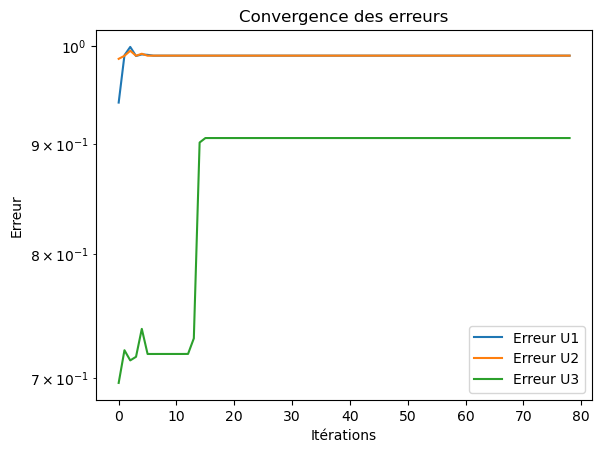

In [199]:
U1,U2,U3,G,erreurU1,erreurU2,erreurU3=Optimization(T, U1, U2, U3, G, max_iter,maxtime,tol)
print_results(erreurU1,erreurU2,erreurU3)